In [ ]:
from wilds.datasets.camelyon17_dataset import Camelyon17Dataset
from wilds.common.data_loaders import get_train_loader, get_eval_loader
from wilds.common.grouper import CombinatorialGrouper
from utils import load
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from models.layers import Identity


In [ ]:
config =  {
        'split_scheme': 'official',
        'model': 'densenet121',
        'model_kwargs': {'pretrained': False},
        'train_transform': 'image_base',
        'eval_transform': 'image_base',
        'target_resolution': (96, 96),
        'loss_function': 'cross_entropy',
        'groupby_fields': ['hospital'],
        'val_metric': 'acc_avg',
        'val_metric_decreasing': False,
        'optimizer': 'SGD',
        'optimizer_kwargs': {'momentum': 0.9},
        'scheduler': None,
        'batch_size': 32,
        'lr': 0.001,
        'weight_decay': 0.01,
        'n_epochs': 5,
        'n_groups_per_batch': 2,
        'irm_lambda': 1.0,
        'coral_penalty_weight': 0.1,
        'algo_log_metric': 'accuracy',
        'process_outputs_function': 'multiclass_logits_to_pred',
    }
def initialize_torchvision_model(name, d_out, **kwargs):
    # get constructor and last layer names
    if name == 'wideresnet50':
        constructor_name = 'wide_resnet50_2'
        last_layer_name = 'fc'
    elif name == 'densenet121':
        constructor_name = name
        last_layer_name = 'classifier'
    elif name in ('resnet50', 'resnet34'):
        constructor_name = name
        last_layer_name = 'fc'
    else:
        raise ValueError(f'Torchvision model {name} not recognized')
    # construct the default model, which has the default last layer
    constructor = getattr(torchvision.models, constructor_name)
    model = constructor(**kwargs)
    # adjust the last layer
    d_features = getattr(model, last_layer_name).in_features
    if d_out is None:  # want to initialize a featurizer model
        last_layer = Identity(d_features)
        model.d_out = d_features
    else: # want to initialize a classifier for a particular num_classes
        last_layer = nn.Linear(d_features, d_out)
        model.d_out = d_out
    setattr(model, last_layer_name, last_layer)
    return model

def initialize_image_base_transform(config, dataset):
    transform_steps = []
    if dataset.original_resolution is not None and min(dataset.original_resolution)!=max(dataset.original_resolution):
        crop_size = min(dataset.original_resolution)
        transform_steps.append(transforms.CenterCrop(crop_size))
    if config['target_resolution'] is not None:
        transform_steps.append(transforms.Resize(config['target_resolution']))
    transform_steps += [
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]
    transform = transforms.Compose(transform_steps)
    return transform

class Camelyon_model(nn.Module):
    def __init__(self, featurizer, classifier):
        super().__init__()
        self.model = torch.nn.Sequential(featurizer, classifier)
        self.featurizer = featurizer
        self.classifier = classifier
        
class Camelyon_model_old(nn.Module):
    def __init__(self, featurizer):
        super().__init__()
#         self.model = torch.nn.Sequential(featurizer, classifier)
        self.model = featurizer
#         self.classifier = classifier

In [ ]:
dataset = Camelyon17Dataset(root_dir="/data/wilds/data")

In [ ]:
train_grouper = CombinatorialGrouper(
        dataset=dataset,
        groupby_fields=['hospital'])

In [ ]:
transform = initialize_image_base_transform(config, dataset)
train_data = dataset.get_subset('train', transform=transform, frac=0.1)
val_data = dataset.get_subset('val', transform=transform, frac=0.1)
test_data = dataset.get_subset('test', transform=transform, frac=0.1)

In [ ]:
train_loader = get_train_loader('group', train_data, grouper=train_grouper, batch_size=15, n_groups_per_batch=3)
val_loader = get_train_loader('standard', val_data, grouper=train_grouper, batch_size=5)
test_loader = get_train_loader('standard', test_data, grouper=train_grouper, batch_size=5)


In [ ]:
# get_eval_loader('group', val_data, grouper=train_grouper, batch_size=16)

In [366]:
ckpt = torch.load('/data/wilds/log/camelyon17_deepCORAL/camelyon17_seed:0_epoch:best_model.pth')

In [ ]:
ckpt['algorithm'].keys()

In [367]:
# Use it for CORALs
featurizer = initialize_torchvision_model('densenet121', d_out=None)
classifier = nn.Linear(featurizer.d_out, 2)
model = (featurizer, classifier)
model = Camelyon_model(featurizer, classifier)
model.load_state_dict(ckpt['algorithm'], strict=True)

# # Use it for ERM and Group DRO
# featurizer = initialize_torchvision_model('densenet121', d_out=2)
# model = Camelyon_model_old(featurizer)
# model.load_state_dict(ckpt['algorithm'], strict=True)
# model.model.classifier = Identity(1024)

<All keys matched successfully>

In [368]:
model.to('cuda:1')
model.eval()
group_list = []
hidden_list = []
label = []
count = 0
with torch.no_grad():
    for b in train_loader:
        inputs, y, group = b
        inputs = inputs.to('cuda:1')
#         outputs = model(inputs)
        groups = train_grouper.metadata_to_group(group)
        features = model.featurizer(inputs) # for CORALs
#         features = model.model(inputs) # for erm groupDRO
        group_list.extend(groups)
        hidden_list.extend(features.cpu().numpy())
        label.extend(y)
        count += 1
#         break
        if count == 20:
            break

count = 0
with torch.no_grad():
    for b in val_loader:
        inputs, y, group = b
        inputs = inputs.to('cuda:1')
#         outputs = model(inputs)
        groups = train_grouper.metadata_to_group(group)
        features = model.featurizer(inputs)
#         features = model.model(inputs)
        group_list.extend(groups)
        hidden_list.extend(features.cpu().numpy())
        label.extend(y)
        count += 1
#         break
        if count == 20:
            break

count = 0
with torch.no_grad():
    for b in test_loader:
        inputs, y, group = b
        inputs = inputs.to('cuda:1')
#         outputs = model(inputs)
        groups = train_grouper.metadata_to_group(group)
        features = model.featurizer(inputs)
#         features = model.model(inputs)
        group_list.extend(groups)
        hidden_list.extend(features.cpu().numpy())
        label.extend(y)
        count += 1
#         break
        if count == 20:
            break

torch.Size([15, 1024])

In [369]:
X = np.array(hidden_list)
y = np.array(group_list)
label = np.array(label)
IND = (y==0) | (y==3) | (y==4)
OOD = (y==2) | (y==1)
INDOOD = (y!=1) #(y==2) | (y==0) #
# OOD = (y==2) 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


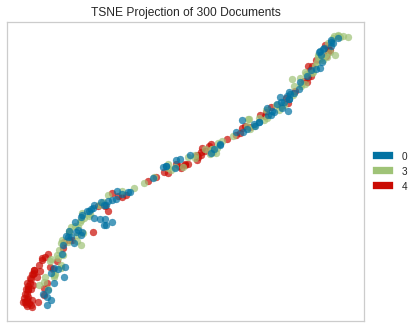

<AxesSubplot:title={'center':'TSNE Projection of 300 Documents'}>

In [370]:
from yellowbrick.text import TSNEVisualizer
import numpy as np
X = np.array(hidden_list)
y = np.array(group_list)

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer(random_state=4)
tsne.fit(X[IND], y[IND])
tsne.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


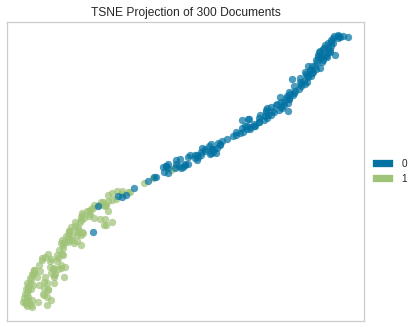

<AxesSubplot:title={'center':'TSNE Projection of 300 Documents'}>

In [371]:
from yellowbrick.text import TSNEVisualizer
import numpy as np
X = np.array(hidden_list)
y = np.array(group_list)

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer(random_state=4)
tsne.fit(X[IND], label[IND])
tsne.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


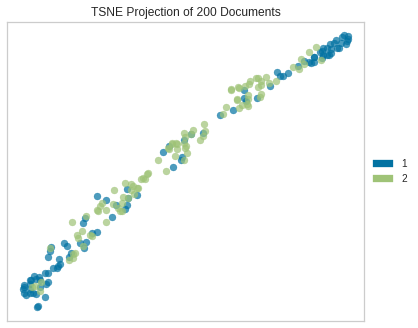

<AxesSubplot:title={'center':'TSNE Projection of 200 Documents'}>

In [372]:
tsne = TSNEVisualizer()
tsne.fit(X[OOD], y[OOD], random_state=42)
tsne.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


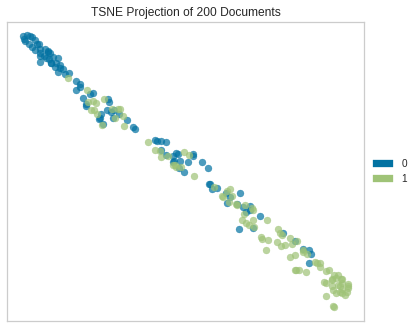

<AxesSubplot:title={'center':'TSNE Projection of 200 Documents'}>

In [373]:
tsne = TSNEVisualizer()
tsne.fit(X[OOD], label[OOD], random_state=43)
tsne.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

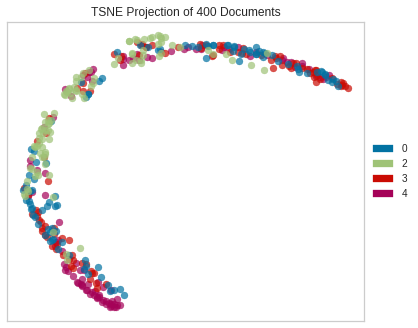

<AxesSubplot:title={'center':'TSNE Projection of 400 Documents'}>

In [374]:
tsne = TSNEVisualizer(random_state=13)
tsne.fit(X[INDOOD], y[INDOOD])
tsne.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


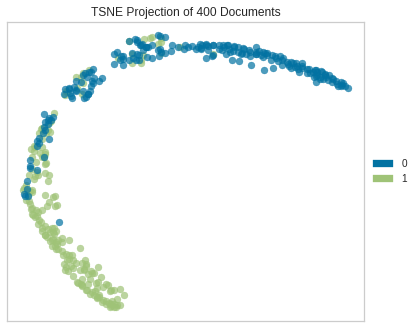

<AxesSubplot:title={'center':'TSNE Projection of 400 Documents'}>

In [375]:
tsne = TSNEVisualizer(random_state=13)
tsne.fit(X[INDOOD], label[INDOOD])
tsne.show()

In [ ]:
tsne = TSNEVisualizer()
tsne.fit(X, y)
tsne.show()

In [ ]:
import umap
from matplotlib import pyplot as plt
import numpy as np


In [ ]:
import pandas as pd
import seaborn as sns

standard_embedding = umap.UMAP(random_state=42).fit_transform(X[IND])
data = pd.DataFrame({"x":standard_embedding[:, 0], "y":standard_embedding[:, 1], "g":y[IND]})
sns.scatterplot(data=data, x="x", y="y", hue="g")

In [ ]:
import pandas as pd
import seaborn as sns

standard_embedding = umap.UMAP(random_state=42).fit_transform(X[INDOOD])
data = pd.DataFrame({"x":standard_embedding[:, 0], "y":standard_embedding[:, 1], "g":y[INDOOD]})
sns.scatterplot(data=data, x="x", y="y", hue="g")

In [ ]:
import pandas as pd
import seaborn as sns

standard_embedding = umap.UMAP(random_state=42).fit_transform(X[OOD])
data = pd.DataFrame({"x":standard_embedding[:, 0], "y":standard_embedding[:, 1], "g":y[OOD]})
sns.scatterplot(data=data, x="x", y="y", hue="g")

In [ ]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(X[OOD])
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=y[OOD].astype(int), s=20)

In [ ]:
sum(label[OOD])/len(label[OOD])